# Regularisation Lasso regression
The following notebook contains pymc models for a Bayesian implementations lasso regression . The model is implemented in fantastic format within the Bayesreg package produced by Makalic & Schmidt (2016). Of which, is expertly explained within great review and methods tutorial paper by Van Erp, Oberski & Mulder (2019). Such a package is very helpful. However, for self pedagogy and modeliing flexibility implementing these models in a differnt PPL is beneficial.

In [50]:
# Import relevant analysis packages.
import pymc as pm
import numpy as np 
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler

In [65]:
# Prediction mean squared error for Bayesian regularized regression model function
# 
def pmse_lm(ppc, ytest):
    # COnvert MCMC sampels into pandas DF
    draws = ppc.to_dataframe()
    # extract only the predicted values
    draws = draws.iloc[:,2:]
    #Generate empty list
    postmeans = []
    # Loop over PPC sampled data set samples and cacculate the mean
    for i in range(np.shape(draws)[1]):
        m = np.mean(draws.iloc[:,i])
        postmeans.append(m)
    
    pmse = np.mean((postmeans-ytest)**2) 
    return pmse
    
def select_p(idata, prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    l = []
    for i in prob:
        hdis = pm.hdi(idata, var_names='beta', hdi_prob=i).to_dataframe()
        for i in range(int(np.shape(hdis)[0]/2)):
            x = hdis.beta[i][['lower','higher'][0]] <= 0 and hdis.beta[i][['lower','higher'][1]] >= 0
            l.append(x)

    chunks = [l[x:x+int(np.shape(hdis)[0]/2)] for x in range(0, len(l), int(np.shape(hdis)[0]/2))]   
    return chunks

In [52]:
# Read dataset from github associated with this notebook.
d = pd.read_csv('https://raw.githubusercontent.com/HPCurtis/Datasets/main/fat.csv', sep=',')
# Copy dataframe for later use
dc = d

# Check for missing values.
if np.sum(np.sum(d.isnull())) >0:
    print('missing values in dataset')
else:
    # Standardise data
    d = pd.DataFrame(StandardScaler().fit_transform(d.iloc[:,1:]))
    
    # Generate regression design matrix
    dm = d.iloc[:, 1:]
    dm.insert(0, '0', np.ones(len(dm)))
    
    #Convert dm to numpy array
    dm = np.asarray(dm)

## Bayesian Lasso regression

In [60]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Priors
    sigma = pm.Uniform("sigma",0, 1e6)
    lamda = pm.HalfCauchy('lamda', 1)
    beta = pm.Laplace("beta", 0, b=sigma/lamda, shape = np.shape(dm)[1])

    mu = pm.math.dot(dm, beta)
    # Likelihood
    y = pm.Normal("y", mu = mu, sigma=sigma, observed = d[0].values)

In [61]:
# Fit and sample the model parameters
with model:
    idata = pymc.sampling_jax.sample_numpyro_nuts()
    ppc = pm.sample_posterior_predictive(idata)

Compiling...
Compilation time =  0:00:03.764720
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y]


Sampling time =  0:00:03.474083
Transforming variables...
Transformation time =  0:00:00.080574


In [62]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.000,0.001,-0.003,0.003,0.000,0.000,6593.0,2616.0,1.0
beta[1],0.961,0.012,0.938,0.984,0.000,0.000,1966.0,2075.0,1.0
beta[2],-0.024,0.009,-0.041,-0.007,0.000,0.000,2540.0,2352.0,1.0
beta[3],-0.001,0.002,-0.005,0.003,0.000,0.000,5382.0,3454.0,1.0
beta[4],0.028,0.014,0.002,0.053,0.000,0.000,1928.0,2474.0,1.0
beta[5],-0.000,0.002,-0.004,0.004,0.000,0.000,5409.0,3105.0,1.0
beta[6],-0.006,0.006,-0.016,0.005,0.000,0.000,3407.0,2839.0,1.0
beta[7],-0.020,0.011,-0.039,0.001,0.000,0.000,1870.0,2199.0,1.0
beta[8],0.000,0.003,-0.005,0.006,0.000,0.000,5362.0,3062.0,1.0
beta[9],0.002,0.004,-0.006,0.011,0.000,0.000,3612.0,3235.0,1.0


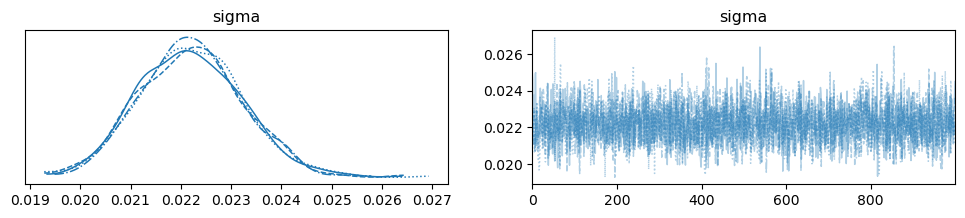

In [59]:
az.plot_trace(idata, var_names='sigma');

In [66]:
select_p(idata)

[[True,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [True,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 [True,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False],
 [True,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  True,
  False,
  False,
  False],
 [True,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  True,
  True,
  True,
  False,
  False,
  True,
  False,
  False,
  False],
 [True,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  True,
  True,
  True,
  False,
  False,
  True,
  False,
  False,
  False],
 [True,
  False,
  False,
  True,
  False,
  True,
  Fa

# References
Van Erp, S., Oberski, D. L., & Mulder, J. (2019). Shrinkage priors for Bayesian penalized regression. Journal of Mathematical Psychology, 89, 31-50.

Makalic, E., & Schmidt, D. F. (2016). High-dimensional Bayesian regularised regression with the BayesReg package. arXiv preprint arXiv:1611.06649.